# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [12]:
! pip install Pillow

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [14]:
! git clone https://github.com/vcasadei/MNIST.git

fatal: destination path 'MNIST' already exists and is not an empty directory.


In [15]:
!ls MNIST

processed  raw


In [16]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [17]:
x_train = x_train.float()

x_train = x_train / 255.

if False:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(np.float64(-0.5), np.float64(232.5), np.float64(87.5), np.float64(-0.5))

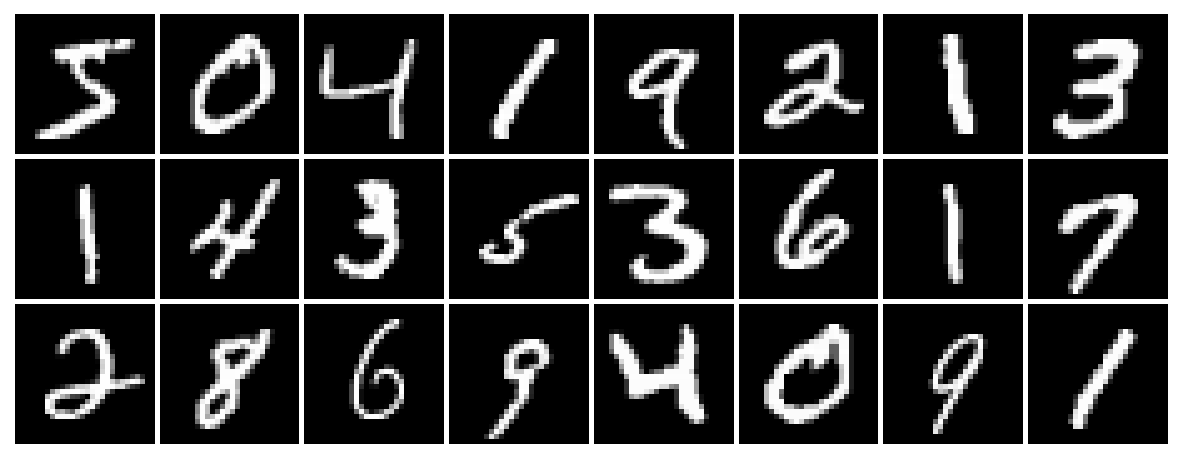

In [18]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


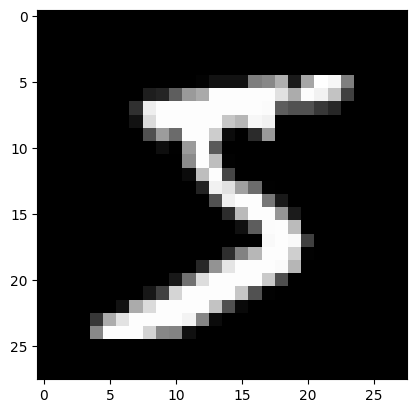

In [19]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [20]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [21]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[ 0.2082, -0.1067,  0.0070,  0.0244, -0.0278,  0.2009, -0.2641,  0.3631,
          0.3762,  0.0466],
        [ 0.2310, -0.3650,  0.2267,  0.1728, -0.1311, -0.0489, -0.2143,  0.3357,
          0.1422, -0.0543],
        [-0.0103, -0.1470, -0.1988,  0.0529,  0.0544, -0.1309, -0.2586,  0.1220,
         -0.0820,  0.1240],
        [ 0.1049, -0.1061,  0.0311,  0.1867, -0.0822,  0.1209, -0.3789,  0.0817,
          0.0558, -0.0683],
        [ 0.0759, -0.2441,  0.1801, -0.2130, -0.0503, -0.2068, -0.4063,  0.0940,
          0.1941,  0.0031]], grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [22]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [23]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.9 MB/s eta 0:00:00
  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-er22c_7a
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-er22c_7a
  Resolved https://github.com/szagoruyko/pytorchviz to commit 5cf04c13e601366f6b9cf5939b5af5144d55b887
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=5040 sha256=a4818a12fcdfded3def2465a3609b37e408b5d6468b80bf63af4049166f9659e
  Stored in directory: /tmp/pip-ephem-wheel-cache-8hfb652y/wheels/63/59/c1/3342e0bca82db7c512109b8da472d40be5c95cca7ce5363332
Successfully built torchviz


In [24]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss


tensor(2.3071, grad_fn=<NllLossBackward0>)

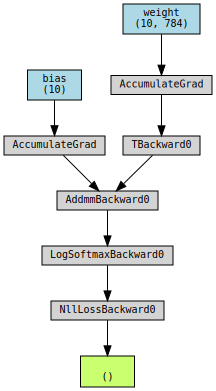

In [25]:
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [26]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()


In [27]:
print('Final loss:', loss.item())

Final loss: 0.3941289484500885


### Visualizando gráfico de perda durante o treinamento

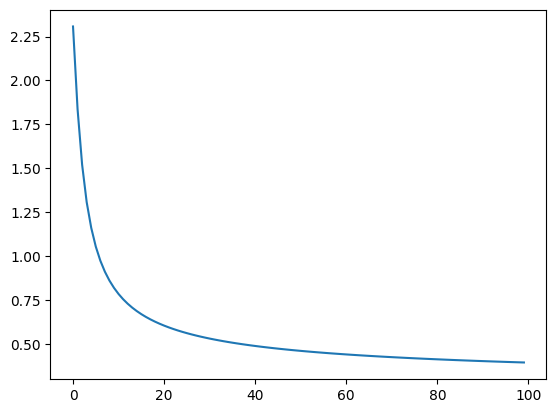

In [28]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [29]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.89395


### Matriz de confusão com dados de treinamento e teste

In [30]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,5678,1,53,35,12,103,48,49,33,48
1,0,6506,78,44,36,72,30,97,176,40
2,25,33,5102,153,40,48,72,99,81,43
3,21,29,96,5286,5,242,5,25,194,103
4,13,5,133,7,5309,90,46,80,26,232
5,43,52,17,257,7,4400,89,11,176,42
6,58,11,127,47,69,113,5566,3,45,4
7,7,16,129,82,15,32,2,5649,39,205
8,70,80,178,141,50,225,58,20,4966,57


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


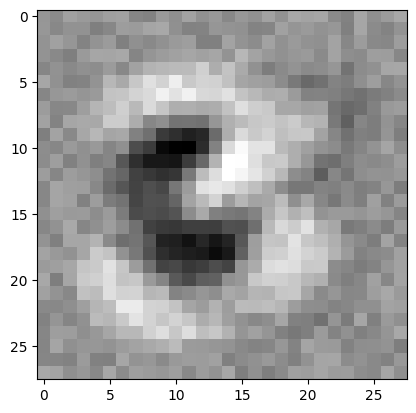

In [31]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

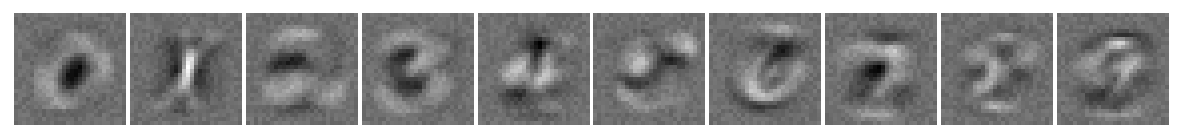

In [32]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

In [ ]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))

    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()

    # Permite que o tensor `outputs` armazene gradientes
    outputs.retain_grad()

    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    print(f"Epoca: {i+1} | Loss: {loss.data}")
    print()


Epoca: 1 | Loss: 0.2965748608112335

Epoca: 2 | Loss: 0.2965260148048401

Epoca: 3 | Loss: 0.2964772582054138

Epoca: 4 | Loss: 0.2964285910129547

Epoca: 5 | Loss: 0.29638001322746277

Epoca: 6 | Loss: 0.2963315546512604

Epoca: 7 | Loss: 0.2962832450866699

Epoca: 8 | Loss: 0.29623499512672424

Epoca: 9 | Loss: 0.2961868345737457

Epoca: 10 | Loss: 0.29613882303237915

Epoca: 11 | Loss: 0.2960909605026245

Epoca: 12 | Loss: 0.2960430681705475

Epoca: 13 | Loss: 0.29599541425704956

Epoca: 14 | Loss: 0.29594776034355164

Epoca: 15 | Loss: 0.29590025544166565

Epoca: 16 | Loss: 0.2958528697490692

Epoca: 17 | Loss: 0.29580554366111755

Epoca: 18 | Loss: 0.29575833678245544

Epoca: 19 | Loss: 0.2957112193107605

Epoca: 20 | Loss: 0.2956642210483551

Epoca: 21 | Loss: 0.2956172823905945

Epoca: 22 | Loss: 0.2955704629421234

Epoca: 23 | Loss: 0.2955237925052643

Epoca: 24 | Loss: 0.2954771816730499

Epoca: 25 | Loss: 0.2954306900501251

Epoca: 26 | Loss: 0.2953842580318451

Epoca: 27 | L

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

<details>
<summary>Mostrar Resultado</summary>

```python
losses = []
import numpy

import numpy
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)
    
    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    _, predicts = torch.max(outputs, 1)
    
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    
    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))
    
    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    # Visualizando pesos da classe 3
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()
```

</details>

In [ ]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))

    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()

    # Permite que o tensor `outputs` armazene gradientes
    outputs.retain_grad()

    loss.backward()

    # Visualizar os gradientes da saída da classe 4
    print("Gradientes da saída da rede para a classe 4:")
    print(outputs.grad[:, 4])  # gradiente do loss com relação à saída da classe 4
    print()

    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    print(f"Epoca: {i+1} | Loss: {loss.data}")
    print()


## Perguntas

1. Qual é o shape da matriz de entrada na rede?
- (6000,28*28)
2. Qual é o shape da saída da rede?
- (6000,10)
3. Qual é o número total de parâmetros da rede, incluindo o bias?
-  784*10 + 10 = 7850

# Aprendizados
